In [223]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt
import seaborn as sns


In [224]:
# TODO: Add total spendings column

In [225]:
# 1) FRESH: annual spending (m.u.) on fresh products (Continuous);
# 2) MILK: annual spending (m.u.) on milk products (Continuous);
# 3) GROCERY: annual spending (m.u.) on grocery products (Continuous);
# 4) FROZEN: annual spending (m.u.) on frozen products (Continuous)
# 5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
# 6) DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous);
# 7) CHANNEL: customers' Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
# 8) REGION: customers' Region - Lisnon, Oporto or Other (Nominal)
# Descriptive Statistics:

# (Minimum, Maximum, Mean, Std. Deviation)
# FRESH ( 3, 112151, 12000.30, 12647.329)
# MILK (55, 73498, 5796.27, 7380.377)
# GROCERY (3, 92780, 7951.28, 9503.163)
# FROZEN (25, 60869, 3071.93, 4854.673)
# DETERGENTS_PAPER (3, 40827, 2881.49, 4767.854)
# DELICATESSEN (3, 47943, 1524.87, 2820.106)

# REGION Frequency
# Lisbon 77
# Oporto 47
# Other Region 316
# Total 440

# CHANNEL Frequency
# Horeca 298
# Retail 142
# Total 440



# 1 Loading the Data, Preprocessing, Initial Data Analysis

In [226]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df = df.drop(columns=["Channel", "Region"])
df_og = df.copy()
df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


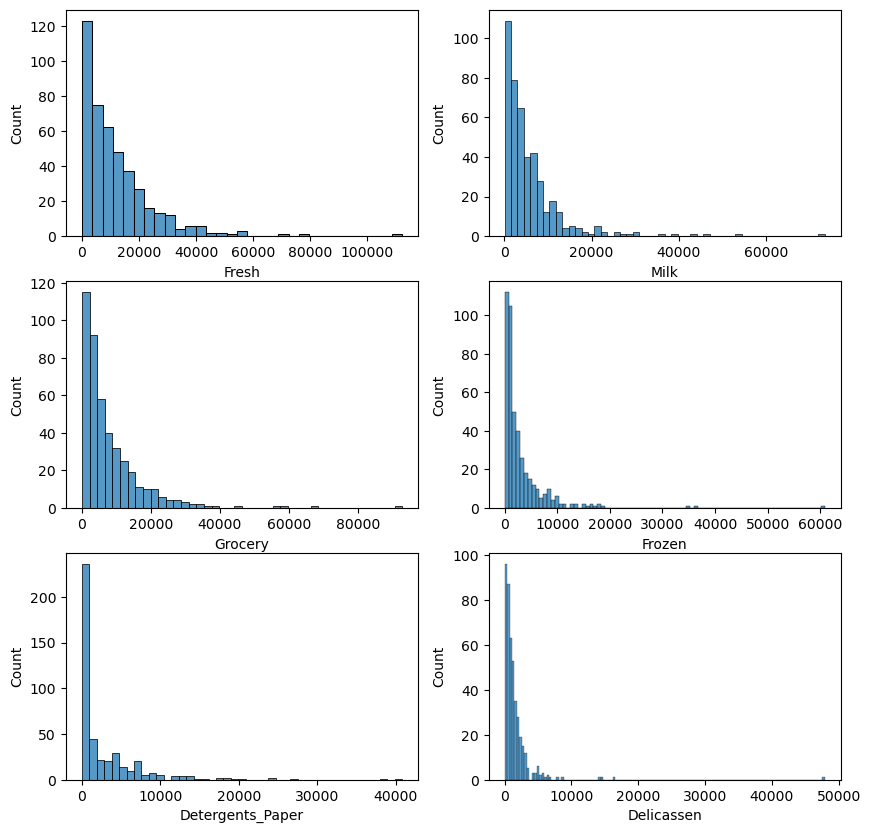

In [227]:
def plot_hist_cols():
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.histplot(df[col], ax=axes[i])


plot_hist_cols()


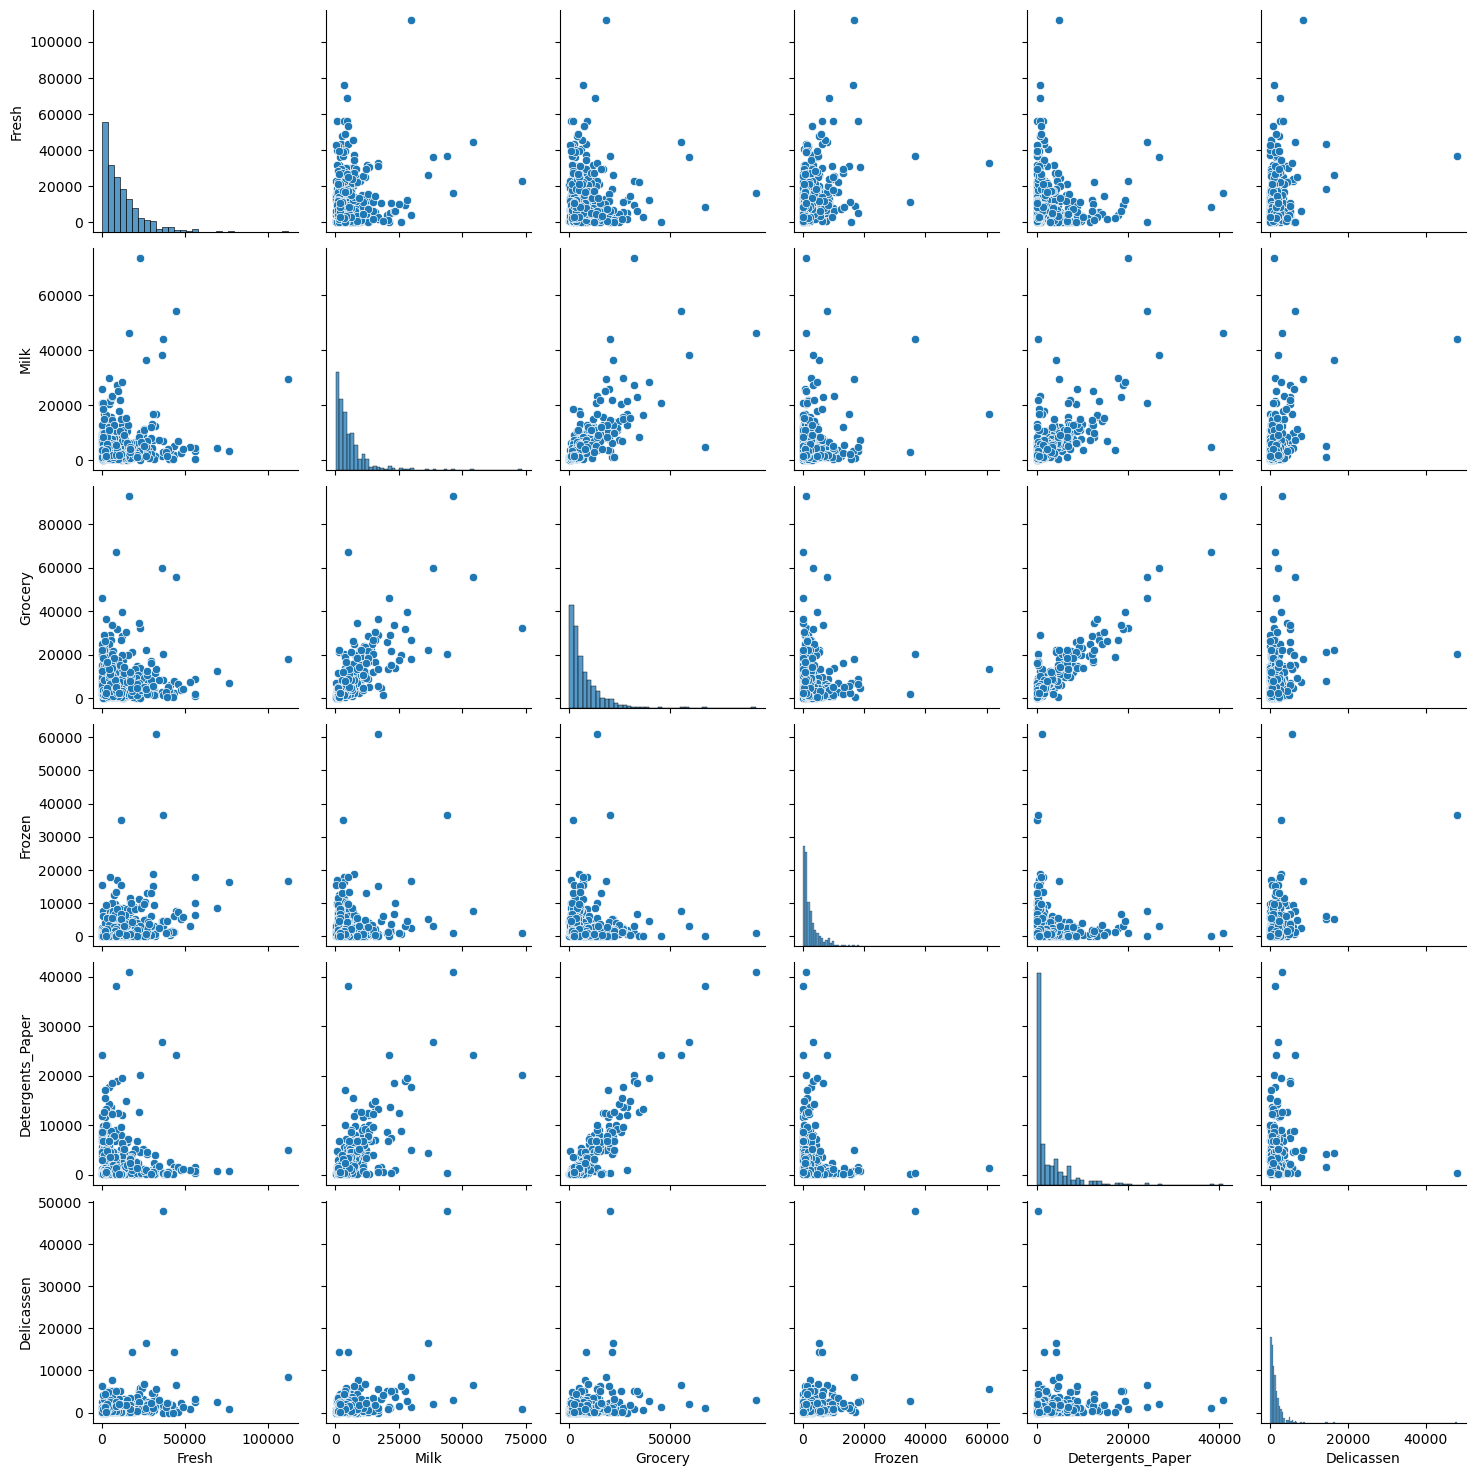

In [228]:
sns.pairplot(df)


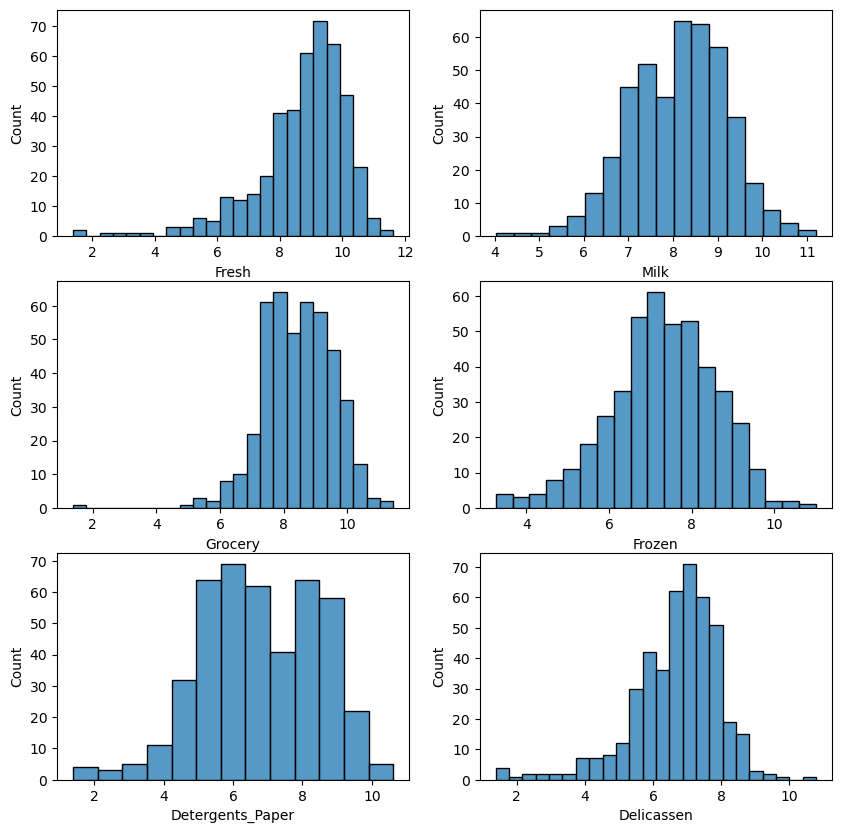

In [229]:
df = np.log(df + 1)
df_overview = df.copy()
plot_hist_cols()


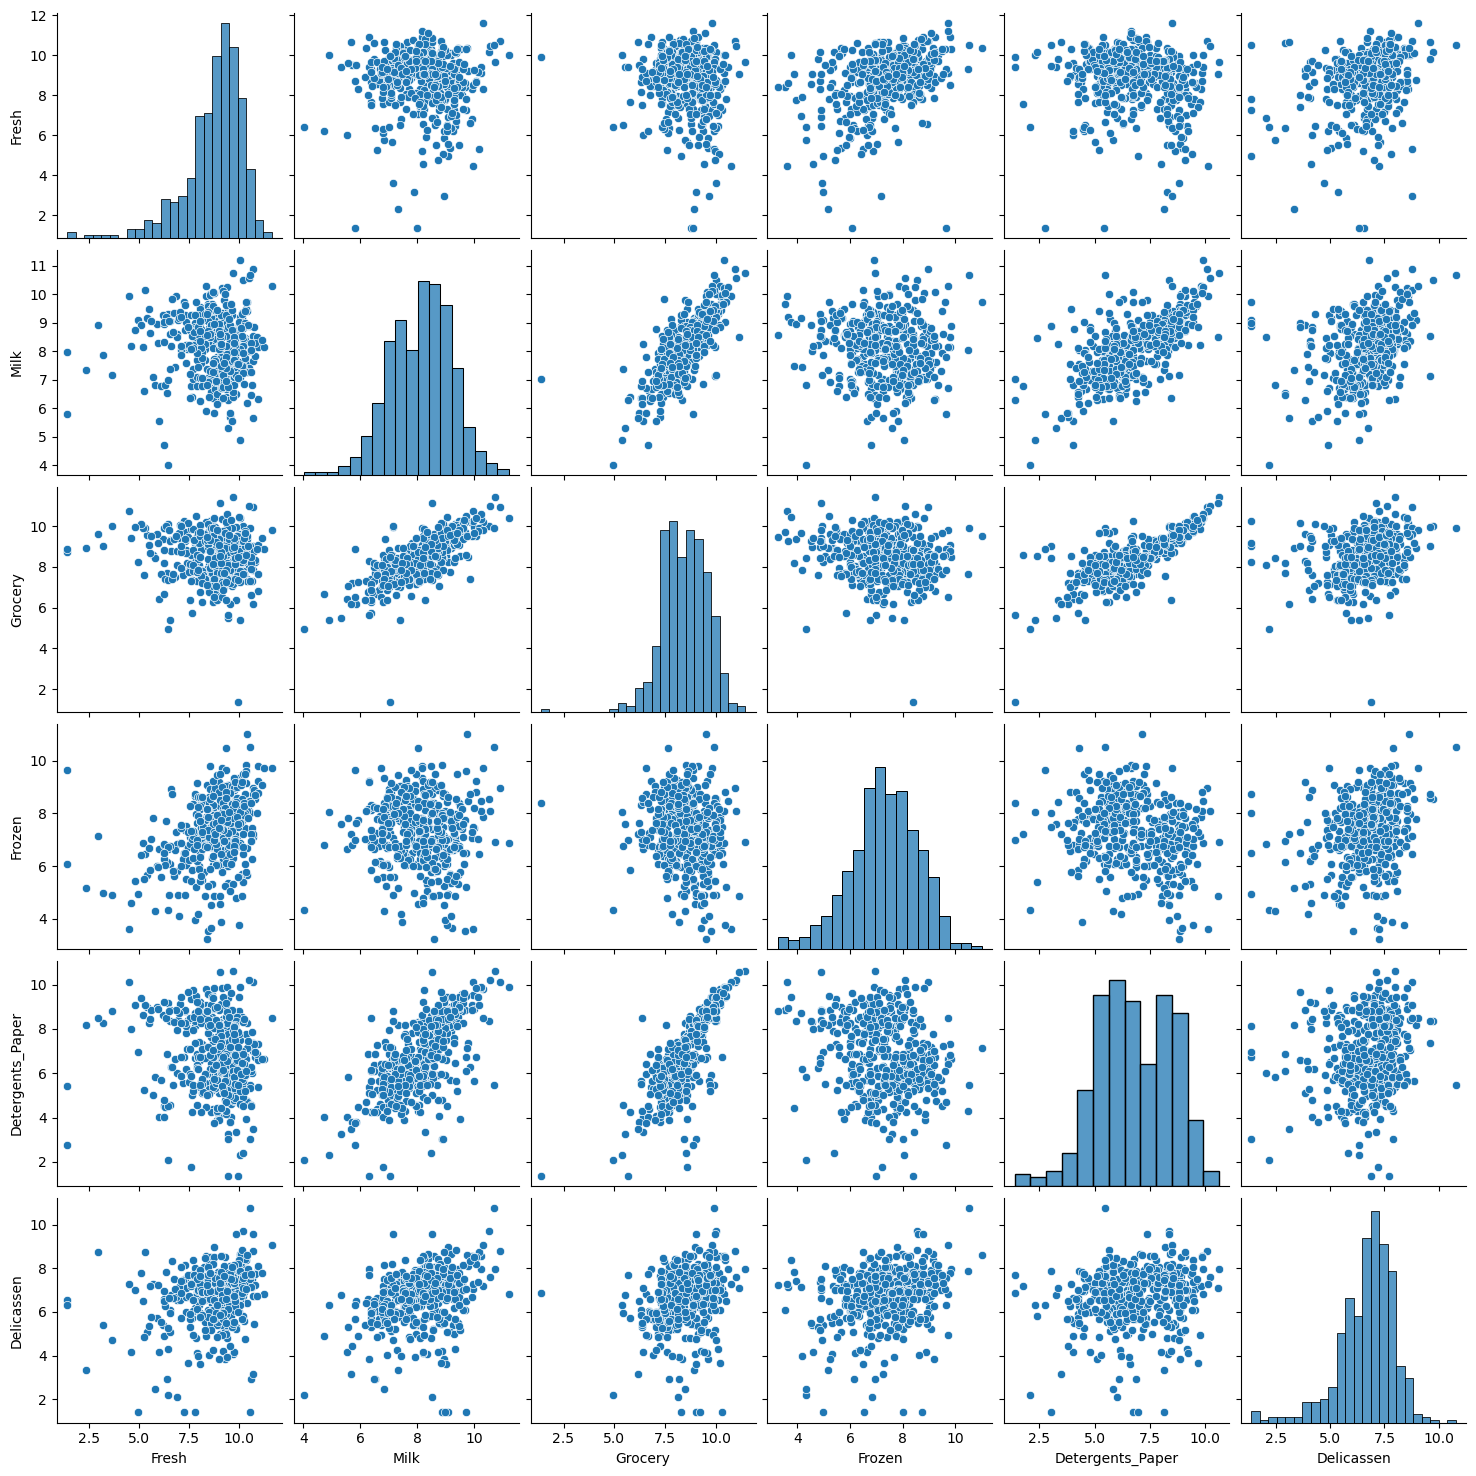

In [230]:
sns.pairplot(df)
# TODO: Add Correlation Plot and a column with total spendings
# Barplot/Pie chart with spendings from total spendings


# 2 Detecting Anomalies
## Hard-Min Score

In [231]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
df_overview["outlier_score_min"] = distances[:, 1]
df_overview.sort_values(by="outlier_score_min", ascending=False).head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,outlier_score_min
338,1.386294,5.811141,8.856803,9.655154,2.772589,6.311735,4.945913
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463,4.647444
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225,4.201955
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294,3.774788
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265,3.746081
187,7.799343,8.987572,9.192176,8.743532,8.149024,1.386294,3.001067
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294,2.973513
183,10.514557,10.690831,9.912001,10.506026,5.480639,10.777789,2.956699
204,7.579168,6.793466,8.561593,7.232733,1.791759,7.192182,2.920883
109,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294,2.721484


In [232]:
print(distances.shape)
# distances: Zeile = sample, Spalte 1 = kürzeste Distanz
# Spalte 0 = alles 0
print(indices.shape)
# indices: erste Spalte 0-440; zweite Spalte: index zur kürzesten Distanz

(440, 2)
(440, 2)


In [233]:
print(distances[0, 1], indices[0])
# quick double check
np.linalg.norm(df.iloc[0, :] - df.iloc[59, :])

1.0869428312265155 [ 0 59]


1.0869428312265155

0.34867098448416445


,outlier_score_min
count,440.000000
mean,1.053147
std,0.591156
min,0.274579
25%,0.742742
50%,0.896719
75%,1.163940
max,4.945913


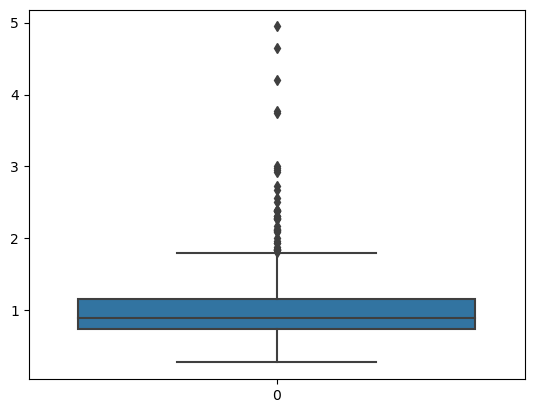

<AxesSubplot: xlabel='outlier_score_min', ylabel='Count'>

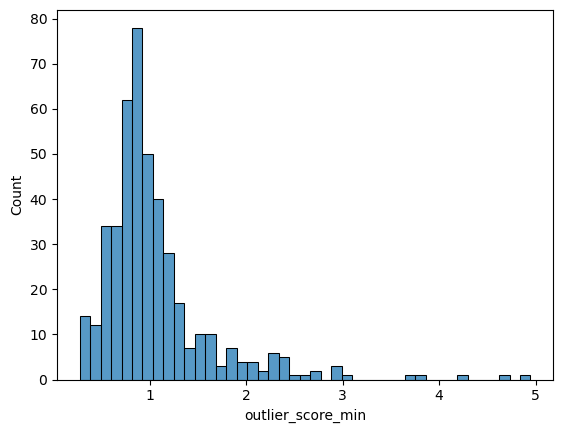

In [234]:
print(np.var(df_overview['outlier_score_min']))
display(df_overview[["outlier_score_min"]].describe())
sns.boxplot(df_overview["outlier_score_min"])
plt.show()
sns.histplot(df_overview["outlier_score_min"])
# want it to be centered/dense!

## Soft-Min Score/KDE approach

In [235]:
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
gamma = 1

def softmin(z, gamma):
    return -1 / gamma * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))


df_overview["outlier_score_softmin"] = np.apply_along_axis(softmin, 1, distances[:, 1:], gamma)
df_overview.sort_values(by="outlier_score_softmin", ascending=False).head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,outlier_score_min,outlier_score_softmin
338,1.386294,5.811141,8.856803,9.655154,2.772589,6.311735,4.945913,8.707924
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225,4.201955,8.125333
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463,4.647444,8.066658
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265,3.746081,7.203478
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294,3.774788,6.732597
66,2.302585,7.336286,8.911665,5.170484,8.151622,3.332205,2.306142,6.593827
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294,2.973513,6.500496
218,2.944439,8.923325,9.629445,7.159292,8.475954,8.759826,2.668450,6.075874
109,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294,2.721484,6.057849
65,4.454347,9.950371,10.732672,3.610918,10.095429,7.261225,2.567014,6.035121


In [164]:
print(distances.shape)

print(np.sum(distances == 0))
distances # aufsteigende Reihenfolge, indices enthält die zugehörigen Indices

(440, 440)
440


array([[ 0.        ,  1.08694283,  1.18434603, ..., 10.56009855,
        10.64258234, 11.02949267],
       [ 0.        ,  0.5071196 ,  0.51741715, ..., 10.09509255,
        10.60971999, 11.1630892 ],
       [ 0.        ,  1.14136835,  1.17054666, ..., 10.23094306,
        10.64797802, 11.91430113],
       ...,
       [ 0.        ,  0.98300836,  1.23805457, ..., 12.04152517,
        12.5997632 , 12.64885026],
       [ 0.        ,  0.88388059,  0.88411931, ...,  8.622275  ,
         8.98060658,  8.99269369],
       [ 0.        ,  2.3751137 ,  2.47130703, ...,  9.66735441,
         9.72841267, 10.40676458]])

0.7869366055138985


,outlier_score_softmin
count,440.000000
mean,3.360544
std,0.888104
min,2.437838
25%,2.801006
50%,3.069082
75%,3.594979
max,8.707924


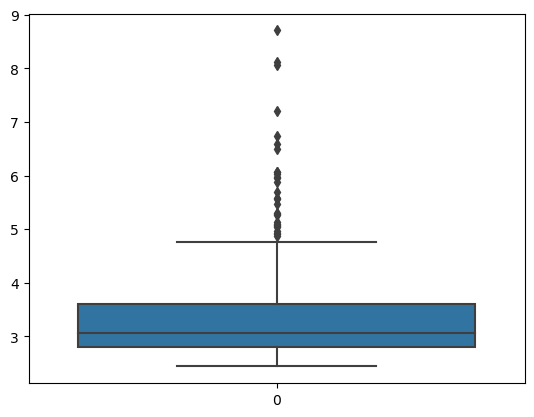

<AxesSubplot: xlabel='outlier_score_softmin', ylabel='Count'>

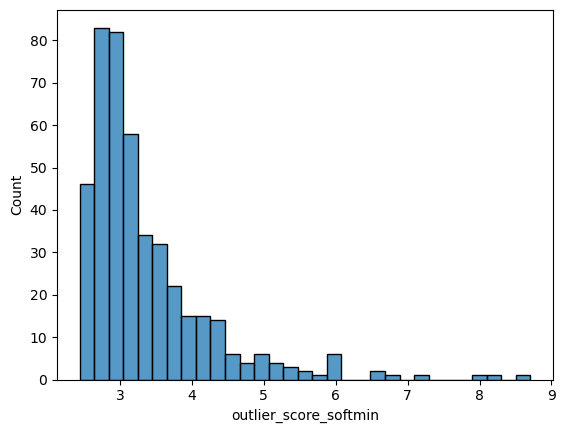

In [165]:
# TODO: Nebeneinander packe

print(np.var(df_overview['outlier_score_softmin']))
display(df_overview[["outlier_score_softmin"]].describe())
sns.boxplot(df_overview["outlier_score_softmin"])
plt.show()
sns.histplot(df_overview["outlier_score_softmin"])

Text(0, 0.5, 'softmin')

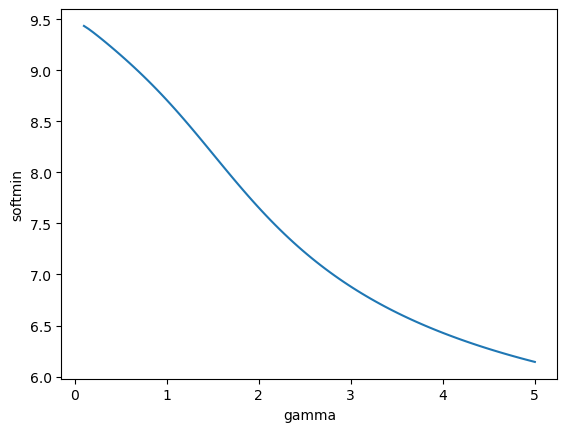

In [259]:
# visualize softmin function for a selected instance
instance = 338  # 338 has had a high outlier score
gammas = np.linspace(0.1, 5, 100)
g = sns.lineplot(
    x=gammas, y=[softmin(distances[instance, 1:], gamma) for gamma in gammas]
)
g.set_xlabel("gamma")
g.set_ylabel("softmin") 


## Bootstrap/Robustness estimate & choosing bandwidth

In [263]:
# TODO should that be the same?
# import statistics
# statistics.fmean(np.exp(-gamma * distances[0, 1:]))
# softmin(distances[instance, 1:], gamma)

In [167]:
from sklearn.utils import resample
N_BOOTSTRAP = 100

spread = {i: np.full(N_BOOTSTRAP, np.nan) for i in range(len(df))}
sample = resample(df, n_samples=len(df) // 2, replace=False)
sample

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
288,9.696525,6.388561,7.167809,6.744059,6.100319,5.556828
104,9.554001,7.665285,8.144969,7.198184,7.307873,6.308098
247,9.515617,5.849325,6.194405,7.639161,3.806662,6.492240
102,7.983781,8.773385,8.946114,7.848543,8.428143,7.234898
405,8.837100,6.953684,7.063048,7.635304,6.386879,5.937536
...,...,...,...,...,...,...
177,9.454071,8.899867,8.419360,7.469084,3.044522,7.875499
280,8.121777,7.967280,7.796469,6.885510,5.123964,7.007601
184,5.793014,6.823286,8.457655,4.317488,5.814131,2.484907
11,9.483949,7.025538,8.417152,7.259116,6.309918,6.210600


In [168]:
spread

{0: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 1: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

In [169]:
g = np.linspace(0.1, 2,10)
gamma_overview = pd.DataFrame(columns=["score_discrimination_var", "model_var"])

for gamma in g:
    spread = {i: np.full(N_BOOTSTRAP, np.nan) for i in range(len(df))}
    for i in range(N_BOOTSTRAP):

        sample = resample(df, n_samples=len(df) // 2, replace=False)

        nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample.to_numpy())
        distances, indices = nbrs.kneighbors(sample.to_numpy())

        sm = np.apply_along_axis(softmin, 1, distances[:, 1:], gamma)

        for j, idx in enumerate(sample.index):
            spread[idx][i] = sm[j]

        #res += [np.var(list(map(np.mean, spread.values())))]
    spread_df = pd.DataFrame(spread) # 100 x 400

    gamma_overview.loc[gamma, "score_discrimination_var"] = np.var(spread_df.mean()) # discriminatory power
    gamma_overview.loc[gamma, "model_var"] = np.mean(np.var(spread_df))


#res
# sns.histplot(list(map(np.std, spread.values())))

In [170]:
spread_df.mean().describe()

count    440.000000
mean       2.829068
std        0.769400
min        2.050155
25%        2.344688
50%        2.589776
75%        3.047267
max        7.741201
dtype: float64

,score_discrimination_var,model_var
0.100000,0.989016,0.00485
0.311111,0.949386,0.004409
0.522222,0.907438,0.004436
0.733333,0.859361,0.004322
0.944444,0.801847,0.004985
1.155556,0.752135,0.006036
1.366667,0.70743,0.007513
1.577778,0.659541,0.007472
1.788889,0.622332,0.009129
2.000000,0.59063,0.010207


<AxesSubplot: ylabel='score_discrimination_var'>

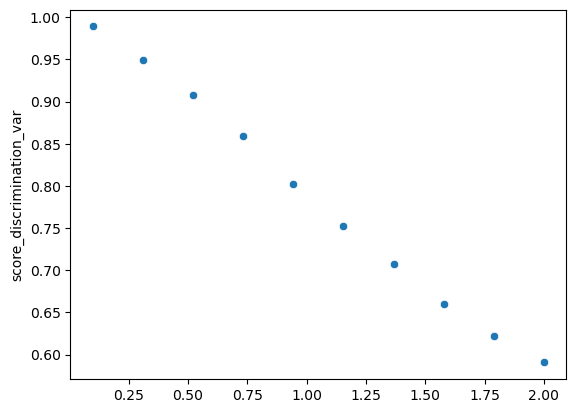

In [171]:
display(gamma_overview)

sns.scatterplot(x=gamma_overview.index, y=gamma_overview["score_discrimination_var"])

<AxesSubplot: ylabel='model_var'>

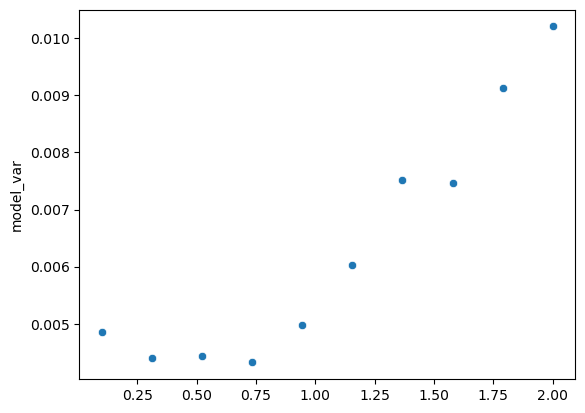

In [172]:
sns.scatterplot(x=gamma_overview.index, y=gamma_overview["model_var"])

In [173]:
spread_df = pd.DataFrame(spread) # 100 x 400
display(spread_df)
g_var_score = np.var(spread_df.mean()) # discriminatory power
g_var_model = np.mean(np.var(spread_df))

#display(spread_df.isna())
# spread_df.isna().sum() # passt

,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439
0,NaN,NaN,2.736100,2.295794,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.924457,NaN,2.308123,3.302650,NaN,2.985282,2.375444,NaN
1,NaN,NaN,2.769272,2.345781,2.549405,NaN,2.490428,NaN,NaN,2.315321,...,3.210999,NaN,NaN,NaN,NaN,NaN,3.054802,2.968707,2.361941,4.104957
2,2.761150,NaN,NaN,NaN,2.516694,NaN,2.361792,NaN,NaN,2.221134,...,3.246301,NaN,2.624319,2.511447,2.258750,3.369941,NaN,2.862715,2.390744,4.102172
3,2.664849,2.139351,2.721206,NaN,NaN,2.358034,2.418079,NaN,2.373818,2.315576,...,3.228695,2.503904,NaN,2.589989,NaN,NaN,NaN,NaN,NaN,4.167378
4,2.685679,NaN,2.730151,2.206912,NaN,NaN,2.330216,NaN,2.276078,NaN,...,3.222114,NaN,2.594513,NaN,NaN,NaN,2.962462,3.057745,NaN,3.976121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,2.716450,2.194134,NaN,NaN,2.464421,NaN,NaN,NaN,...,3.270920,2.618898,2.756172,NaN,2.306237,NaN,NaN,2.914123,NaN,NaN
96,NaN,NaN,NaN,2.298399,2.535826,NaN,2.394081,2.176948,2.310119,2.231399,...,NaN,NaN,2.603737,NaN,NaN,3.359284,NaN,NaN,2.396377,4.146516
97,NaN,2.188252,2.739284,NaN,NaN,NaN,NaN,2.169920,NaN,NaN,...,NaN,2.704976,2.788922,2.437471,2.261406,NaN,NaN,2.876570,NaN,4.071658
98,2.574039,NaN,NaN,2.404895,2.494856,2.220764,2.314710,NaN,2.313384,2.291808,...,NaN,NaN,NaN,2.608373,2.162433,3.420874,NaN,NaN,2.444452,NaN


In [174]:
spread_df.isna().sum()

0      46
1      51
2      42
3      45
4      59
       ..
435    42
436    51
437    38
438    48
439    59
Length: 440, dtype: int64

In [175]:
np.array([1,2,3,4]).shape

(4,)

In [176]:
spread

{0: array([       nan,        nan, 2.76114973, 2.66484895, 2.68567894,
               nan, 2.6198197 , 2.78254703,        nan,        nan,
               nan, 2.69213008, 2.77663979, 2.73564889,        nan,
        2.59887566,        nan,        nan, 2.60920105, 2.75905861,
        2.68165002, 2.71871669,        nan, 2.68184836,        nan,
               nan,        nan, 2.62692211,        nan, 2.66066399,
        2.6915452 , 2.68679683,        nan,        nan, 2.59575934,
        2.68636238, 2.90035673, 2.65497877, 2.72368976, 2.83822334,
        2.65915559, 2.76719861,        nan,        nan,        nan,
        2.69849456,        nan,        nan, 2.63668011, 2.8030072 ,
        2.8057872 , 2.70652091, 2.79579692, 2.72946583,        nan,
               nan, 2.77185314,        nan, 2.66445763, 2.60407098,
        2.69220892,        nan, 2.62629241,        nan, 2.72424905,
        2.63051901,        nan,        nan,        nan,        nan,
        2.7271051 , 2.74863092,        nan, 2

In [177]:
sample = resample(df, n_samples=len(df) // 2, replace=False)
sample.head()
nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample.to_numpy())
distances, indices = nbrs.kneighbors(sample.to_numpy())
sm = np.apply_along_axis(softmin, 1, distances[:, 1:], gamma)
sm

array([2.340938  , 6.96636483, 2.31088861, 2.64626292, 2.3681173 ,
       4.47620566, 5.38007834, 2.31326638, 2.6979958 , 2.45289787,
       3.11966268, 3.01605137, 2.79206584, 4.03734489, 3.65531946,
       3.066056  , 3.58059509, 2.38158783, 2.52809372, 3.43923136,
       3.93868197, 3.25379962, 2.34951422, 3.19985322, 2.82461534,
       2.94134822, 2.25693799, 2.77558247, 2.29284963, 2.39417766,
       2.56437076, 3.02753759, 2.35750991, 2.40736985, 2.57224773,
       2.88554332, 2.3861854 , 2.29360053, 2.41042935, 2.86215859,
       3.14712445, 2.57638621, 2.9235226 , 2.19624092, 3.19804473,
       2.25619534, 2.69722329, 2.95551807, 2.18488461, 3.08528381,
       2.19708893, 2.41910541, 2.96313726, 2.22746519, 2.31094034,
       2.93517101, 2.32761913, 3.11780642, 3.54263661, 3.10237642,
       2.22198116, 2.76529003, 2.51412632, 2.3133328 , 3.36086921,
       2.21967856, 2.22023181, 2.3087754 , 2.35344332, 2.66650894,
       2.55337579, 3.34218419, 6.74783602, 2.29420394, 2.53044

In [178]:
list(map(np.std, spread.values()))

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [179]:
spread

{0: array([       nan,        nan, 2.76114973, 2.66484895, 2.68567894,
               nan, 2.6198197 , 2.78254703,        nan,        nan,
               nan, 2.69213008, 2.77663979, 2.73564889,        nan,
        2.59887566,        nan,        nan, 2.60920105, 2.75905861,
        2.68165002, 2.71871669,        nan, 2.68184836,        nan,
               nan,        nan, 2.62692211,        nan, 2.66066399,
        2.6915452 , 2.68679683,        nan,        nan, 2.59575934,
        2.68636238, 2.90035673, 2.65497877, 2.72368976, 2.83822334,
        2.65915559, 2.76719861,        nan,        nan,        nan,
        2.69849456,        nan,        nan, 2.63668011, 2.8030072 ,
        2.8057872 , 2.70652091, 2.79579692, 2.72946583,        nan,
               nan, 2.77185314,        nan, 2.66445763, 2.60407098,
        2.69220892,        nan, 2.62629241,        nan, 2.72424905,
        2.63051901,        nan,        nan,        nan,        nan,
        2.7271051 , 2.74863092,        nan, 2

need 2 measures to compare: robustness vs. value of score (how much it discriminates between outliers and "regular" points); check picture from Montavon. Visual examination/optimal point. Compare to hard min


Cluster = Partition der Daten um sie zusammenzufassen, nicht unbedingt obvious

# TEST FOR ALTERNATIVE TAKE ON EX 2

In [264]:
def clean_distances(z):
    if z[0] == 0:
        return z[1:]
    else:
        return z[0:-1]

def softmin2(z, gamma):
    return softmin(clean_distances(z), gamma)

In [339]:
gamma_space = np.linspace(0.1, 2, 20)
scores = np.zeros((len(df), N_BOOTSTRAP * 2, len(gamma_space)))


def get_distances(hole, part):
    nbrs = NearestNeighbors(n_neighbors=len(part), algorithm="ball_tree").fit(part)
    distances, indices = nbrs.kneighbors(hole)
    distances = np.apply_along_axis(clean_distances, 1, distances)
    return distances


for i in range(0, N_BOOTSTRAP * 2, 2):
    # randomly split df into two (50/50)
    part1 = df.sample(frac=0.5)
    part2 = df.drop(part1.index)

    distances1 = get_distances(df, part1)
    distances2 = get_distances(df, part2)

    for j, gamma in enumerate(gamma_space):
        scores[:, i, j] = np.apply_along_axis(softmin, 1, distances1, gamma)
        scores[:, i + 1, j] = np.apply_along_axis(softmin, 1, distances2, gamma)


In [325]:
scores.shape

(440, 200, 20)

<AxesSubplot: >

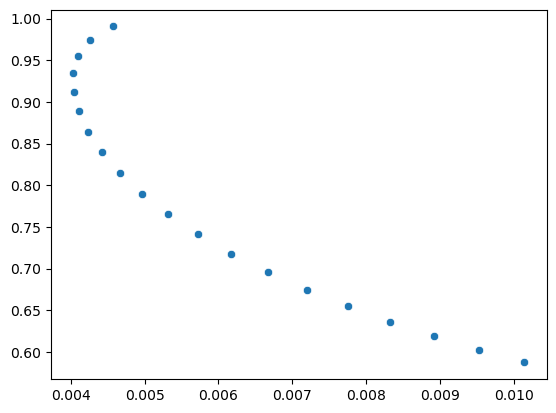

In [340]:
sns.scatterplot(y=np.var(np.mean(scores, axis=1), axis=0), x=np.mean(np.var(scores, axis=1), axis=0))

# 3 Explaining Anomalies

In [213]:
gamma = 1

nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)

z = np.square(distances[:, 1:])

# First, one identifies to what extent each data point has contributed to the anomaly score of instance j

# calculate anomaly score
yj = np.apply_along_axis(softmin, 1, z, gamma)

# # caculate squared euclidean norms
# zk = np.square(distances[:, 1:])

# temp = np.exp(-gamma * zk)
# Rkj = temp / np.sum(temp, axis=1)[:, None] * yj[:, None]
# Rkj

In [214]:
# TEST FOR SINGLE INSTANCE
# TODO: SOMETHING IS NOT CORRECT 

j = 0

x = df.to_numpy()

# 1.
temp = np.exp(-gamma * np.square(np.linalg.norm(x - x[j], axis=1)))
temp[j] = 0
Rk = temp / np.sum(temp) * yj

# 2.
n = np.square(x - x[j]) 
dn = np.square(np.linalg.norm(x - x[j], axis=1))
dn[j] = 1

R = (np.sum(n / dn[:, None] * Rk[:, None], axis=0))
print(R)
print(np.sum(np.sum(n / dn[:, None] * Rk[:, None], axis=0)))
print(yj[j])

[0.94611853 0.62713944 0.27161023 1.56960186 0.48649585 0.54495546]
4.445921366197124
5.0984655205477605


In [215]:
Rji = np.zeros((440, 6))

for j in range(len(df)):

    # 1.
    temp = np.exp(-gamma * np.square(np.linalg.norm(x - x[j], axis=1)))
    temp[j] = 0
    Rk = temp / np.sum(temp) * yj

    # 2.
    n = np.square(x - x[j]) 
    dn = np.square(np.linalg.norm(x - x[j], axis=1))
    dn[j] = 1

    Rji[j,:] = (np.sum(n / dn[:, None] * Rk[:, None], axis=0))

Rji

array([[0.94611853, 0.62713944, 0.27161023, 1.56960186, 0.48649585,
        0.54495546],
       [0.96835398, 0.71840755, 0.29784063, 0.84277391, 0.55374717,
        0.46958338],
       [0.6745419 , 0.50424118, 0.23120475, 0.44123832, 0.36463034,
        1.82948191],
       ...,
       [0.48230466, 0.35637876, 0.46360569, 1.6821473 , 0.70227605,
        0.67938937],
       [0.88284475, 0.51711933, 0.31391467, 0.86065753, 0.4330318 ,
        1.01349882],
       [1.14827283, 0.6828382 , 0.99618419, 1.72510223, 0.35969908,
        1.75857728]])

/var/folders/d7/6rwzv4n55v385stdz71392180000gn/T/ipykernel_46743/219968405.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


Text(0.5, 0, 't-SNE 2')

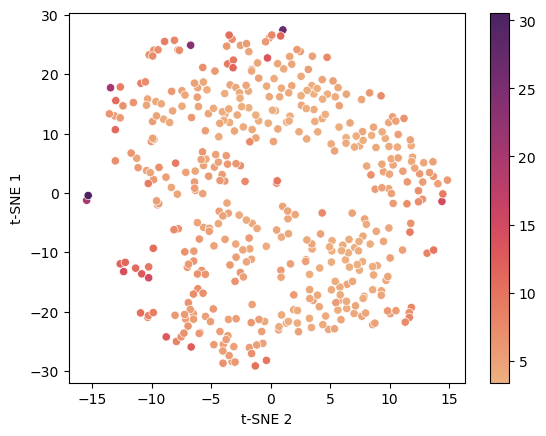

In [216]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(df)

ax = sns.scatterplot(x=X_embedded[:,1], y=X_embedded[:,0], hue=yj, palette='flare')

norm = plt.Normalize(yj.min(), yj.max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

ax.set_ylabel("t-SNE 1")
ax.set_xlabel("t-SNE 2")

Fresh               1.386294
Milk                5.811141
Grocery             8.856803
Frozen              9.655154
Detergents_Paper    2.772589
Delicassen          6.311735
Name: 338, dtype: float64

(0.004521115979383794, 10.385429981291116)

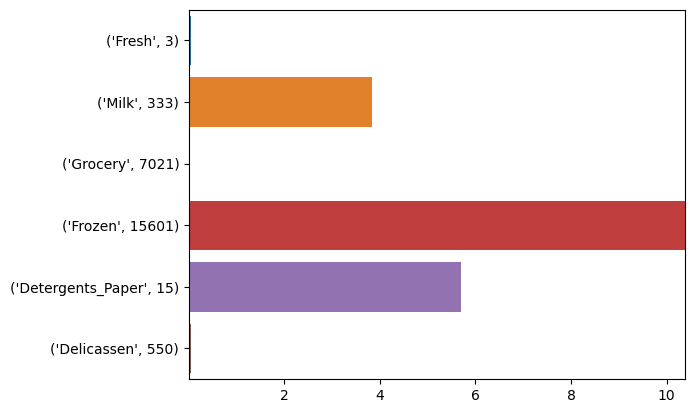

In [217]:
instance = 338
display(df.iloc[instance])
g = sns.barplot(x=Rji[instance], y=list(map(str, list(zip(df_og.iloc[instance].index, df_og.iloc[instance].values)))))
g.set_xlim(np.min(Rji),np.max(Rji))